# GİRİŞ
Burada veri setinin alınması, özelliklerin çıkarılması ve eğitim işlemleri sağlanacaktır.

## Gerekli Modüller
- Numpy verileri eğitime hazırlanmak ve daha öncesinde kayıt edilen numpy veri dosyaların alınması için kullanılacaktır.
- Librosa tek boyutlu ses sinyallerinden mel frekans spektrogram katsayısını çıkarmak için kullanılacaktır.

In [ ]:
import numpy as np
import librosa as lb

In [ ]:
datasets_path = r"/content/drive/MyDrive/Bitirme/Uygulama/Datasets/" #Veri setinin bulunduğu dizin.

## Veri Setinin Okunması
Veri setinin dinamik bir şekilde kullanılması açısından daha öncesinden kayıt edilmişti. Kaydedilen numpy dosyaları okundu.

In [ ]:
data = np.load(datasets_path+"/TESS/data.npy")
labels = np.load(datasets_path+"/TESS/labels.npy")


## MFCC Özellik Çıkarıcı
Her bir ses dosyası gezilip mel frekans spektral katsayısı hesaplatıldı ve yeniden boyutlandırılıp features liste elemanına atandı.

In [ ]:
features = []
for i in data:
  features.append((lb.feature.mfcc(y=i).reshape(1200,1)))
features = np.array(features)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
LB = LabelBinarizer()
label = LB.fit_transform(labels)

In [ ]:
label.shape

(2800, 7)

## Veri Setinin Bölünmesi
Eğitim ve test işlemleri için tüm RAVDESS veri seti %80'e %20 olacak şekilde random (rastgele) bir şekilde ayrılıdı. Eğitim 2240 ve test 560 veri sayıları.

In [ ]:
from sklearn.model_selection import train_test_split
(x_train,x_test,y_train,y_test) = train_test_split(features,label,random_state = 25,test_size = 0.20)
print("Train Veri Sayısı:",x_train.shape[0])
print("Test Veri Sayısı:",x_test.shape[0])

Train Veri Sayısı: 2240
Test Veri Sayısı: 560


In [ ]:
y_test.shape

(560, 7)

# Model

## Model Modülleri
Model için gerekli modeüllerin ve fonksiyonların tanımlanması.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop,Adam

## Modelin Oluşturulması
Model tek katmanlı evrişimli sinir ağı olarak tasarlandı.

In [ ]:
model = Sequential()
model.add(Conv1D(filters=256,kernel_size=5, input_shape=(1200,1), activation='relu',padding='same'))
model.add(Conv1D(128, 5,padding='same',activation='relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',activation='relu'))
model.add(Flatten())
model.add(Dense(7, activation='softmax'))

## Modelin Derlenmesi
Optimizasyon algoritması olarak Adam seçildi. Başlangıç öğrenme oranı (lr) 0.0001 kayıp fonksiyonu olarak 'categorical_crossentropy' başarı metriği doğruluk olarak belirlendi.

In [ ]:
#opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Modelin Eğitimi
Eğitimde eğitim (train) ve doğrulama (validation) veriyle 10 dönem-defa (epoch) 100 mini-batchler halinde eğitildi. Eğitim sonuçları cnnhistory değişkenine atandı.

In [ ]:
cnnhistory=model.fit(x_train, y_train, batch_size= 100, epochs=10)

Epoch 1/10
23/23 [==============================] - 45s 58ms/step - loss: 5.8423 - accuracy: 0.0979
Epoch 2/10
23/23 [==============================] - 1s 51ms/step - loss: 2.2383 - accuracy: 0.2513
Epoch 3/10
23/23 [==============================] - 1s 51ms/step - loss: 1.5624 - accuracy: 0.4022
Epoch 4/10
23/23 [==============================] - 1s 51ms/step - loss: 1.1531 - accuracy: 0.6188
Epoch 5/10
23/23 [==============================] - 1s 52ms/step - loss: 0.9040 - accuracy: 0.7239
Epoch 6/10
23/23 [==============================] - 1s 51ms/step - loss: 0.7136 - accuracy: 0.8058
Epoch 7/10
23/23 [==============================] - 1s 52ms/step - loss: 0.5631 - accuracy: 0.8695
Epoch 8/10
23/23 [==============================] - 1s 51ms/step - loss: 0.4578 - accuracy: 0.9001
Epoch 9/10
23/23 [==============================] - 1s 51ms/step - loss: 0.3975 - accuracy: 0.9133
Epoch 10/10
23/23 [==============================] - 1s 51ms/step - loss: 0.3269 - accuracy: 0.9329


# Modelin Sonuçları

## Modelin Test Edilmesi
Test için ayrılan veriler ile model 5 mini-batchler halinde test edildi

In [ ]:
score = model.evaluate(x_test,y_test,batch_size=5)

112/112 [==============================] - 1s 4ms/step - loss: 0.3297 - accuracy: 0.9393


In [ ]:
model.summary() # Modelin Özeti 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1200, 256)         1536      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1200, 128)         163968    
_________________________________________________________________
dropout (Dropout)            (None, 1200, 128)         0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 150, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 150, 128)          82048     
_________________________________________________________________
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 1

In [ ]:
save_model_path = r"/content/drive/MyDrive/Bitirme/Uygulama/Save_Model"
model.save(save_model_path+"/TESS/cnn1d.h5")

## Doğruluk ve Kayıp Sonuçları
Eğitim sonuçları grafiksel olarak görselleştirildi.

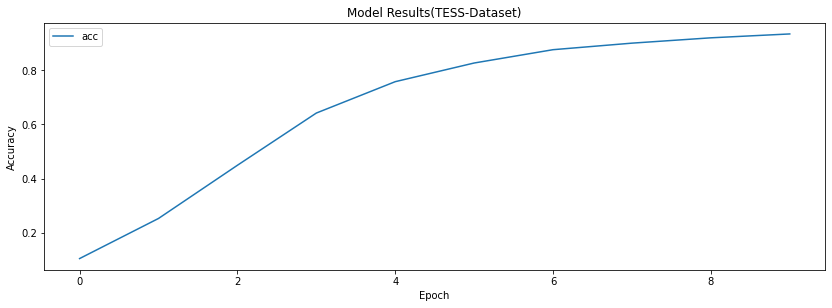

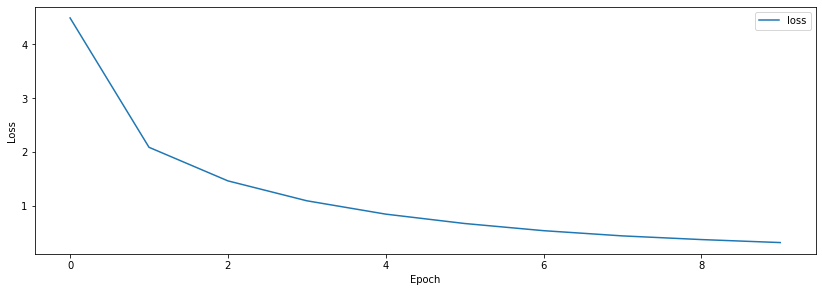

In [ ]:
import matplotlib.pyplot as plt

plt.figure(1, figsize = (14, 10))  
plt.subplot(211)  
plt.plot(cnnhistory.history['accuracy'])
plt.title('Model Results(TESS-Dataset)')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['acc'], loc='upper left')     
plt.show()
plt.figure(2, figsize = (14, 10))  
plt.subplot(212)  
plt.plot(cnnhistory.history['loss'])  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['loss'], loc='upper right')     
plt.show()

# Sınıflandırmanın raporunun ve karmaşılık matrisinin çıkarımı


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
report = classification_report(true_classes, predicted_classes, target_names=["Angry","Disgust","Fear","Happy","Netural","PS","Sad"])
conf_mat = confusion_matrix(true_classes, predicted_classes)

In [ ]:
print(report)

              precision    recall  f1-score   support

       Angry       0.95      0.95      0.95        76
     Disgust       0.92      0.99      0.96        86
        Fear       0.93      0.92      0.92        84
       Happy       0.96      0.95      0.95        74
     Netural       0.95      0.96      0.96        78
          PS       0.92      0.89      0.90        87
         Sad       0.96      0.93      0.95        75

    accuracy                           0.94       560
   macro avg       0.94      0.94      0.94       560
weighted avg       0.94      0.94      0.94       560



In [ ]:
label_names = ["Ang","Dis","Fe ","Hap","Net","PS ","Sad"]
print("     Ang   Dis  Fe   Hap  Net  PS   Sad")
sayac = 0
for i in conf_mat:

    st = ""
    for j in i:
        st = st + "  " +str(j)+"  "
    print(label_names[sayac],st)
    sayac +=1

     Ang   Dis  Fe   Hap  Net  PS   Sad
Ang   72    0    2    0    0    2    0  
Dis   0    85    0    1    0    0    0  
Fe    4    0    77    2    0    1    0  
Hap   0    0    0    70    0    4    0  
Net   0    0    0    0    75    0    3  
PS    0    6    4    0    0    77    0  
Sad   0    1    0    0    4    0    70  
